In [1]:
from pandas_datareader import data as pdr
import pandas as pd
import yfinance as yf
import numpy as np
from datetime import datetime 
yf.pdr_override() # <== that's all it takes :-)
pd.set_option('display.max_rows',None)
# download dataframe
data = pdr.get_data_yahoo("^NSEI", start="2022-12-01", end="2023-02-06")
#print(data.columns)
#upper_band=((high+low)/2)+(multiplier*atr)
#lower_band=((high+low)/2)-(multiplier*atr)
#print(data.columns)
df=pd.DataFrame(data,columns=['Open','High','Low','Close'])
df.reset_index(inplace = True)
print(df.head(5))
df['Date']=pd.to_datetime(df['Date']).dt.date
#print(df.head(5))
print(df.info())


[*********************100%***********************]  1 of 1 completed
                       Date          Open          High           Low  \
0 2022-12-01 00:00:00+05:30  18871.949219  18887.599609  18778.199219   
1 2022-12-02 00:00:00+05:30  18752.400391  18781.949219  18639.199219   
2 2022-12-05 00:00:00+05:30  18719.550781  18728.599609  18591.349609   
3 2022-12-06 00:00:00+05:30  18600.650391  18654.900391  18577.900391   
4 2022-12-07 00:00:00+05:30  18638.849609  18668.300781  18528.400391   

          Close  
0  18812.500000  
1  18696.099609  
2  18701.050781  
3  18642.750000  
4  18560.500000  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    46 non-null     object 
 1   Open    46 non-null     float64
 2   High    46 non-null     float64
 3   Low     46 non-null     float64
 4   Close   46 non-null     float64
dtypes: float64(4), obj

In [2]:
df[['Open','High','Low','Close']]=df[['Open','High','Low','Close']].apply(lambda x:np.round(x,2),axis=1)

In [3]:
def true_range(df):
    df['Prev_Close']=df['Close'].shift(1)
    #Find high-low-prevclose combination
    df['high-low']=df['High']-df['Low']
    df['high-prev_close']=abs(df['High']-df['Prev_Close'])
    df['low-prev_close']=abs(df['Low']-df['Prev_Close'])
    tr=df[['high-low','high-prev_close','low-prev_close']].max(axis=1)
    return tr

In [4]:
def atr(df,period=14):
    df['TR']=true_range(df)
    atr_v=df['TR'].rolling(period).mean()
    #EMA(df, 'TR', atr, period, alpha=True)
    #return df
    return np.round(atr_v,2)

In [23]:
def supertrend(df,period,multiplier=2.5):
    df['long']=pd.Series(np.full(len(df),np.nan))
    df['short']=pd.Series(np.full(len(df),np.nan))
    print('supertrend calculator')
    df['atr']=atr(df,period=period)
    #df['atr_rma']=df['true_range'].ewm(alpha=1/period,min_periods=lengt).mean()
    df['uband']=((df['High']+df['Low'])/2)+(multiplier*df['atr'])
    df['lband']=((df['High']+df['Low'])/2)-(multiplier*df['atr'])
    df['is_uptrend']=True
    for current in range(1,len(df)):
        previous=current-1
        if df['Close'][current]>df['uband'][previous]:
            df['is_uptrend'][current]=True
        elif df['Close'][current]<df['lband'][previous]:
            df['is_uptrend'][current]=False
        else:
            df['is_uptrend'][current]=df['is_uptrend'][previous]
            
            if df['is_uptrend'][current] and df['lband'][current]<df['lband'][previous]:
                df['lband'][current]=df['lband'][previous]
            
            if not df['is_uptrend'][current] and df['uband'][current]>df['uband'][previous]:
                df['uband'][current]=df['uband'][previous]
        
        if df['is_uptrend'][current]:
            df['long'][current]=df['lband'][current]#=np.nan
        else:
            df['short'][current]=df['uband'][current]
            
           
    return df

In [28]:
df

,Open,High,Low,Close,long,short,Prev_Close,high-low,high-prev_close,low-prev_close,TR,atr,uband,lband,is_uptrend
Date,,,,,,,,,,,,,,,
2022-12-01,18871.95,18887.60,18778.20,18812.50,NaN,NaN,NaN,109.40,NaN,NaN,109.40,NaN,NaN,NaN,True
2022-12-02,18752.40,18781.95,18639.20,18696.10,NaN,NaN,18812.50,142.75,30.55,173.30,173.30,NaN,NaN,NaN,True
2022-12-05,18719.55,18728.60,18591.35,18701.05,NaN,NaN,18696.10,137.25,32.50,104.75,137.25,NaN,NaN,NaN,True
2022-12-06,18600.65,18654.90,18577.90,18642.75,NaN,NaN,18701.05,77.00,46.15,123.15,123.15,NaN,NaN,NaN,True
2022-12-07,18638.85,18668.30,18528.40,18560.50,NaN,NaN,18642.75,139.90,25.55,114.35,139.90,NaN,NaN,NaN,True
2022-12-08,18570.85,18625.00,18536.95,18609.35,NaN,NaN,18560.50,88.05,64.50,23.55,88.05,NaN,NaN,NaN,True
2022-12-09,18662.40,18664.70,18410.10,18496.60,NaN,NaN,18609.35,254.60,55.35,199.25,254.60,NaN,NaN,NaN,True
2022-12-12,18402.15,18521.55,18345.70,18497.15,NaN,NaN,18496.60,175.85,24.95,150.90,175.85,NaN,NaN,NaN,True
2022-12-13,18524.40,18617.25,18490.20,18608.00,NaN,NaN,18497.15,127.05,120.10,6.95,127.05,NaN,NaN,NaN,True


In [7]:
def EMA(df, base, target, period, alpha=False):
    """
    Function to compute Exponential Moving Average (EMA)
    Args :
        df : Pandas DataFrame which contains ['date', 'open', 'high', 'low', 'close', 'volume'] columns
        base : String indicating the column name from which the EMA needs to be computed from
        target : String indicates the column name to which the computed data needs to be stored
        period : Integer indicates the period of computation in terms of number of candles
        alpha : Boolean if True indicates to use the formula for computing EMA using alpha (default is False)
    Returns :
        df : Pandas DataFrame with new column added with name 'target'
    """

    con = pd.concat([df[:period][base].rolling(window=period).mean(), df[period:][base]])

    if (alpha == True):
        # (1 - alpha) * previous_val + alpha * current_val where alpha = 1 / period
        df[target] = con.ewm(alpha=1 / period, adjust=False).mean()
    else:
        # ((current_val - previous_val) * coeff) + previous_val where coeff = 2 / (period + 1)
        df[target] = con.ewm(span=period, adjust=False).mean()

    df[target].fillna(0, inplace=True)
    return df

In [24]:
df=supertrend(df,period=14,multiplier=2.5)

supertrend calculator


C:\Users\aps\AppData\Local\Temp\ipykernel_19840\1550329082.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_uptrend'][current]=df['is_uptrend'][previous]
C:\Users\aps\AppData\Local\Temp\ipykernel_19840\1550329082.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['long'][current]=df['lband'][current]#=np.nan
C:\Users\aps\AppData\Local\Temp\ipykernel_19840\1550329082.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

In [25]:
df

,Open,High,Low,Close,long,short,Prev_Close,high-low,high-prev_close,low-prev_close,TR,atr,uband,lband,is_uptrend
Date,,,,,,,,,,,,,,,
2022-12-01,18871.95,18887.60,18778.20,18812.50,NaN,NaN,NaN,109.40,NaN,NaN,109.40,NaN,NaN,NaN,True
2022-12-02,18752.40,18781.95,18639.20,18696.10,NaN,NaN,18812.50,142.75,30.55,173.30,173.30,NaN,NaN,NaN,True
2022-12-05,18719.55,18728.60,18591.35,18701.05,NaN,NaN,18696.10,137.25,32.50,104.75,137.25,NaN,NaN,NaN,True
2022-12-06,18600.65,18654.90,18577.90,18642.75,NaN,NaN,18701.05,77.00,46.15,123.15,123.15,NaN,NaN,NaN,True
2022-12-07,18638.85,18668.30,18528.40,18560.50,NaN,NaN,18642.75,139.90,25.55,114.35,139.90,NaN,NaN,NaN,True
2022-12-08,18570.85,18625.00,18536.95,18609.35,NaN,NaN,18560.50,88.05,64.50,23.55,88.05,NaN,NaN,NaN,True
2022-12-09,18662.40,18664.70,18410.10,18496.60,NaN,NaN,18609.35,254.60,55.35,199.25,254.60,NaN,NaN,NaN,True
2022-12-12,18402.15,18521.55,18345.70,18497.15,NaN,NaN,18496.60,175.85,24.95,150.90,175.85,NaN,NaN,NaN,True
2022-12-13,18524.40,18617.25,18490.20,18608.00,NaN,NaN,18497.15,127.05,120.10,6.95,127.05,NaN,NaN,NaN,True


In [37]:
def signal_generation(df):
    #for live data-->Fetch the last two row values
    last_row=len(df)-1
    previous_row=len(df)-2
    if df['is_uptrend'][previous_row] and not df['is_uptrend'][current_row]:
        print('sell signal generated')
    
    if df['is_uptrend'][current_row] and not df['is_uptrend'][previous_row]:
        print('buy signal generated')

In [10]:
df.set_index('Date',inplace=True)

In [11]:
df

,Open,High,Low,Close,long,short,Prev_Close,high-low,high-prev_close,low-prev_close,TR,atr,uband,lband,is_uptrend
Date,,,,,,,,,,,,,,,
2022-12-01,18871.95,18887.60,18778.20,18812.50,NaN,NaN,NaN,109.40,NaN,NaN,109.40,NaN,NaN,NaN,True
2022-12-02,18752.40,18781.95,18639.20,18696.10,NaN,NaN,18812.50,142.75,30.55,173.30,173.30,NaN,NaN,NaN,True
2022-12-05,18719.55,18728.60,18591.35,18701.05,NaN,NaN,18696.10,137.25,32.50,104.75,137.25,NaN,NaN,NaN,True
2022-12-06,18600.65,18654.90,18577.90,18642.75,NaN,NaN,18701.05,77.00,46.15,123.15,123.15,NaN,NaN,NaN,True
2022-12-07,18638.85,18668.30,18528.40,18560.50,NaN,NaN,18642.75,139.90,25.55,114.35,139.90,NaN,NaN,NaN,True
2022-12-08,18570.85,18625.00,18536.95,18609.35,NaN,NaN,18560.50,88.05,64.50,23.55,88.05,NaN,NaN,NaN,True
2022-12-09,18662.40,18664.70,18410.10,18496.60,NaN,NaN,18609.35,254.60,55.35,199.25,254.60,NaN,NaN,NaN,True
2022-12-12,18402.15,18521.55,18345.70,18497.15,NaN,NaN,18496.60,175.85,24.95,150.90,175.85,NaN,NaN,NaN,True
2022-12-13,18524.40,18617.25,18490.20,18608.00,NaN,NaN,18497.15,127.05,120.10,6.95,127.05,NaN,NaN,NaN,True


In [24]:
df1=df.copy()

In [27]:
df=df1[:30]

In [27]:
df

,Open,High,Low,Close,long,short,Prev_Close,high-low,high-prev_close,low-prev_close,TR,atr,uband,lband,is_uptrend
Date,,,,,,,,,,,,,,,
2022-12-01,18871.95,18887.60,18778.20,18812.50,NaN,NaN,NaN,109.40,NaN,NaN,109.40,NaN,NaN,NaN,True
2022-12-02,18752.40,18781.95,18639.20,18696.10,NaN,NaN,18812.50,142.75,30.55,173.30,173.30,NaN,NaN,NaN,True
2022-12-05,18719.55,18728.60,18591.35,18701.05,NaN,NaN,18696.10,137.25,32.50,104.75,137.25,NaN,NaN,NaN,True
2022-12-06,18600.65,18654.90,18577.90,18642.75,NaN,NaN,18701.05,77.00,46.15,123.15,123.15,NaN,NaN,NaN,True
2022-12-07,18638.85,18668.30,18528.40,18560.50,NaN,NaN,18642.75,139.90,25.55,114.35,139.90,NaN,NaN,NaN,True
2022-12-08,18570.85,18625.00,18536.95,18609.35,NaN,NaN,18560.50,88.05,64.50,23.55,88.05,NaN,NaN,NaN,True
2022-12-09,18662.40,18664.70,18410.10,18496.60,NaN,NaN,18609.35,254.60,55.35,199.25,254.60,NaN,NaN,NaN,True
2022-12-12,18402.15,18521.55,18345.70,18497.15,NaN,NaN,18496.60,175.85,24.95,150.90,175.85,NaN,NaN,NaN,True
2022-12-13,18524.40,18617.25,18490.20,18608.00,NaN,NaN,18497.15,127.05,120.10,6.95,127.05,NaN,NaN,NaN,True


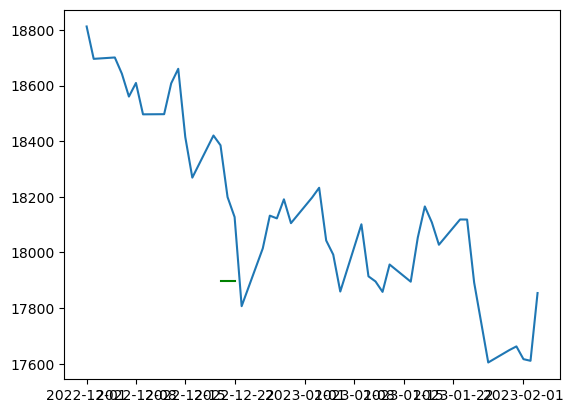

In [26]:
# visualization

from matplotlib import pyplot as plt

plt.plot(df.index,df['Close'], label='Close Price')
plt.plot(df.index,df['long'], c='g', label = 'Final Lowerband')
#plt.plot(df['uband'], 'r', label = 'Final Upperband')
plt.show()